# Assignment 12: Decision Tree Classifier


In [1]:
import sklearn.datasets
import sklearn.tree
import numpy as np
import math
import pandas as pd

# Task 1. Data Preprocessing

In [2]:
iris_bunch = sklearn.datasets.load_iris(as_frame=True)
iris = iris_bunch.frame[iris_bunch.frame.target != 2] # currently 0 is for setosa and 1 for versicolor
iris = iris.replace({'target': {1: 0,0:1} }) # now 1 is for setosa and 0 for versicolor
gp  = iris.groupby(['target'])

iris_setosa = gp.get_group((1,))
iris_versicolor = gp.get_group((0,))

X = iris_setosa.iloc[:,:4].to_numpy(np.float32)
Y = iris_setosa.iloc[:,4].to_numpy(np.float32)

X_train,X_test = X[0:(X.shape[0]*8)//10],X[(X.shape[0]*8)//10:]
Y_train,Y_test = Y[0:(X.shape[0]*8)//10],Y[(X.shape[0]*8)//10:]

X = iris_versicolor.iloc[:,:4].to_numpy(np.float32)
Y = iris_versicolor.iloc[:,4].to_numpy(np.float32)

X_train = np.concatenate((X_train,X[0:(X.shape[0]*8)//10]),axis = 0)
X_test = np.concatenate((X_test,X[(X.shape[0]*8)//10:]),axis = 0)

Y_train = np.concatenate((Y_train,Y[0:(Y.shape[0]*8)//10]),axis = 0)
Y_test = np.concatenate((Y_test,Y[(Y.shape[0]*8)//10:]),axis = 0)

# Task 2. Decision Tree Implementation

In [3]:
class DecisionTreeNode:
    def __init__(self,index : int,threshold: float,isLeaf : bool,label = None) -> None:
        self.index = index
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.label = label
        self.right = None
        self.left = None
    
    def decide(self,input):
        if(self.isLeaf == True): return self.label
        if(input[self.index] < self.threshold) : return self.left.decide(input)
        return self.right.decide(input)

def calculate_entropy(y):
    one_len = y[y[:,4] == 1].shape[0]
    zero_len = y[y[:,4] == 0].shape[0]    
    p_one = one_len/(one_len + zero_len)
    p_zero = zero_len/(one_len + zero_len)
    ret = 0
    if(p_one != 0): ret += p_one*math.log2(1/p_one)
    if(p_zero != 0): ret += p_zero*math.log2(1/p_zero) 
    return ret

def information_gain(y,y_left,y_right):
    return calculate_entropy(y) - (len(y_left)/(len(y_left) + len(y_right)))*calculate_entropy(y_left) - (len(y_right)/(len(y_left) + len(y_right)))*calculate_entropy(y_right)

def get_threshold(C,feature):
    sorted_indices = np.argsort(C[:, feature])
    sorted_array = C[sorted_indices]
    
    threshold = sorted_array[sorted_array.shape[0]-1,feature]
    for i in range(sorted_array.shape[0]-2,-1,-1):
        if sorted_array[i,4] == sorted_array[i+1,4]:
            threshold = sorted_array[i,feature]
        else: break
    return threshold


def best_split(X, y):
    C = np.concatenate((X,np.expand_dims(y,axis = 0).T),axis = 1)
    ig = {}
    threshold = [0,0,0,0]
    for feature in range(4):
        threshold[feature] = get_threshold(C,feature)
        ig[feature] = information_gain(C,
                                       C[C[:,feature] < threshold[feature]],
                                       C[C[:,feature] >= threshold[feature]]
                                        )
    max_feature = 0

    for f,info_gain in ig.items():
        if info_gain > ig[max_feature]:
            max_feature = f

    return max_feature,threshold[max_feature]

def build_tree(X,y,max_depth):

   
    if(y[y == 1].shape[0] == y.shape[0]):
       
        return DecisionTreeNode(-1,-1,True,1)
    if(y[y == 0].shape[0] == y.shape[0]):
      
        return DecisionTreeNode(-1,-1,True,0)

    if(max_depth == 0):
        one_len = y[y == 1].shape[0]
        zero_len = y[y == 0].shape[0]
        if(one_len > zero_len):
            return DecisionTreeNode(-1,-1,True,1)
        else:
            return DecisionTreeNode(-1,-1,True,0)
    
    

    max_feature,threshold = best_split(X,y)
    root = DecisionTreeNode(max_feature,threshold,False)
    root.left = build_tree(X[X[:,max_feature] < threshold],y[X[:,max_feature] < threshold],max_depth -1)
    root.right = build_tree(X[X[:,max_feature] >= threshold],y[X[:,max_feature] >= threshold],max_depth -1)
    return root

In [4]:
def predict_single_instance(x, tree):
    return tree.decide(x)

def predict_decision_tree(X_test, tree):
    preds = []
    for i in range(X_test.shape[0]):
        preds.append(tree.decide(X_test[i]))
    return np.array(preds)

def accuracy(y_pred,y_true):
    correct = 0
    for i in range(y_true.shape[0]):
        if y_pred[i] == y_true[i]:
            correct+=1
    return correct/y_true.shape[0] 


In [5]:
for i in range(1,11):
    tree = build_tree(X_train,Y_train,i)
    preds  = predict_decision_tree(X_test,tree)
    print(f"Accuracy of self-made Decision Tree with max depth = {i} : {accuracy(preds,Y_test)}")

Accuracy of self-made Decision Tree with max depth = 1 : 0.95
Accuracy of self-made Decision Tree with max depth = 2 : 0.95
Accuracy of self-made Decision Tree with max depth = 3 : 0.95
Accuracy of self-made Decision Tree with max depth = 4 : 0.95
Accuracy of self-made Decision Tree with max depth = 5 : 0.95
Accuracy of self-made Decision Tree with max depth = 6 : 0.95
Accuracy of self-made Decision Tree with max depth = 7 : 0.95
Accuracy of self-made Decision Tree with max depth = 8 : 0.95
Accuracy of self-made Decision Tree with max depth = 9 : 0.95
Accuracy of self-made Decision Tree with max depth = 10 : 0.95


# Task 3. Comparison with Scikit-Learn

In [6]:
tree = build_tree(X_train,Y_train,5)
preds  = predict_decision_tree(X_test,tree)

sk_tree = sklearn.tree.DecisionTreeClassifier(max_depth = 5)
sk_tree.fit(X_train,Y_train)
sk_pred = sk_tree.predict(X_test)

print(f"Accuracy of self-made Decision Tree: {accuracy(preds,Y_test)}")
print(f"Accuracy of sklearn Decision Tree: {accuracy(sk_pred,Y_test)}")


Accuracy of self-made Decision Tree: 0.95
Accuracy of sklearn Decision Tree: 1.0


# Task 4. Visualization and Analysis

[Text(0.5, 0.75, 'x[3] <= 0.75\ngini = 0.5\nsamples = 80\nvalue = [40, 40]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 40\nvalue = [0, 40]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 40\nvalue = [40, 0]'),
 Text(0.625, 0.5, '  False')]

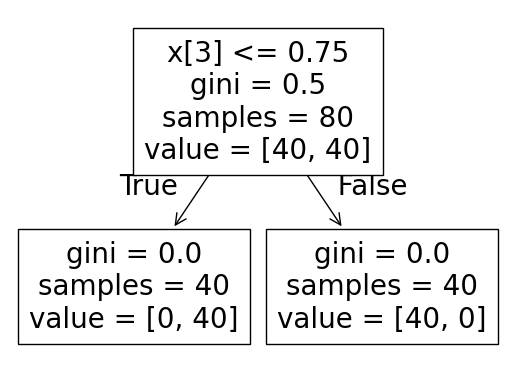

In [7]:
sklearn.tree.plot_tree(sk_tree)

## Analysis: Examine the performance of the Decision Tree classifier:


Q1 – How does the maximum depth max_depth affect the accuracy and overfitting of the model?<br>
Ans - In this example the max_depth does not really affect the overfitting of the model as it is able to achieve 100% accuracy on training data with only 1 depth.<br><br>
Q2 – What are the strengths and limitations of using a Decision Tree for this binary classification problem?<br>
Ans - With good choice of feature and threshold it is possible to achieve 100% accuracy in this test set for all max_depth values.<br>So there are no notable limitations shown by Dicision Tree in this example